In [11]:
import torch
import torchphysics as tp
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"


In [12]:
X = tp.spaces.R2('x')
T = tp.spaces.R1('t')

A1 = tp.domains.Circle(X, center=[0.5, 0.5], radius=0.5)
A2 = tp.domains.Circle(X, center=[0.5, 0.5], radius=lambda t: 0.5*t)
B = tp.domains.Interval(T, 0, 1)

C = (A1*B - A2*B)

points = C.sample_random_uniform(d=8000)

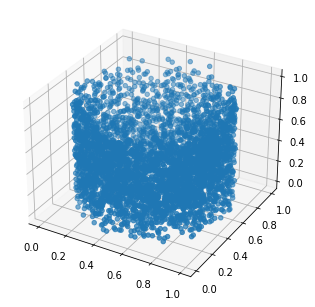

In [13]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

fig = pyplot.figure()
ax = Axes3D(fig)
ax.scatter(points[:,'x'].as_tensor[:,0].cpu(), points[:,'x'].as_tensor[:,1].cpu(), points[:,'t'].as_tensor.cpu())

In [14]:
sampler = tp.samplers.RandomUniformSampler(C, density=1e6)

U = tp.spaces.R1('u')
model = tp.models.FCN(input_space=X*T, output_space=U, hidden=(20,20,20))

def residual(u, x, t):
    return tp.utils.laplacian(u, x) - tp.utils.grad(u, t)

condition = tp.conditions.PINNCondition(model,
                                        sampler,
                                        residual_fn=residual)

In [15]:
solver = tp.solver.Solver([condition])

import pytorch_lightning as pl

trainer = pl.Trainer(gpus=1,
                     max_steps=1000,
                     logger=False,
                     benchmark=True,
                     checkpoint_callback=False)
trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 941   
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
941       Trainable params
0         Non-trainable params
941       Total params
0.004     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

In [16]:
len(sampler.sample_points())

523909